# Channel Attribution Analysis

## Imports

In [ ]:
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt 
import sklearn
import numpy as np
import pickle
import joblib
import itertools
from sklearn.linear_model import LogisticRegression

In [ ]:
sns.set()

## Read the Dataset

- Cookie: Randomly generated customer id enabling us to tie subsequent visits back to the same customer
- Timestamp: Date and time when the visit took place
- Interaction: Categorical variable indicating the type of interaction that took place
- Conversion: Boolean variable indicating whether a conversion took place
- Conversion Value: Value of the potential conversion event
- Channel: The marketing channel that brought the customer to our site

In [ ]:
df = pd.read_csv("attribution data.csv"); df.head().T

0                          1  \
cookie            00000FkCnDfDDf0iC97iC703B  00000FkCnDfDDf0iC97iC703B   
time                   2018-07-03T13:02:11Z       2018-07-17T19:15:07Z   
interaction                      impression                 impression   
conversion                                0                          0   
conversion_value                        0.0                        0.0   
channel                           Instagram             Online Display   

                                          2                          3  \
cookie            00000FkCnDfDDf0iC97iC703B  00000FkCnDfDDf0iC97iC703B   
time                   2018-07-24T15:51:46Z       2018-07-29T07:44:51Z   
interaction                      impression                 impression   
conversion                                0                          0   
conversion_value                        0.0                        0.0   
channel                      Online Display             Online Display   

                                          4  
cookie            0000nACkD9nFkBBDECD3ki00E  
time                   2018-07-03T09:44:57Z  
interaction                      impression  
conversion                                0  
conversion_value                        0.0  
channel                         Paid Search

In [ ]:
df.shape

(586737, 6)

In [ ]:
df.describe(include='all')

cookie                  time interaction  \
count                      586737                586737      586737   
unique                     240108                485110           2   
top     FDkCnkBiB7FiE9oBDC7ifn7kF  2018-07-14T20:50:09Z  impression   
freq                          134                    12      569098   
mean                          NaN                   NaN         NaN   
std                           NaN                   NaN         NaN   
min                           NaN                   NaN         NaN   
25%                           NaN                   NaN         NaN   
50%                           NaN                   NaN         NaN   
75%                           NaN                   NaN         NaN   
max                           NaN                   NaN         NaN   

           conversion  conversion_value   channel  
count   586737.000000     586737.000000    586737  
unique            NaN               NaN         5  
top               NaN               NaN  Facebook  
freq              NaN               NaN    175741  
mean         0.030063          0.187871       NaN  
std          0.170760          1.084498       NaN  
min          0.000000          0.000000       NaN  
25%          0.000000          0.000000       NaN  
50%          0.000000          0.000000       NaN  
75%          0.000000          0.000000       NaN  
max          1.000000          8.500000       NaN

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586737 entries, 0 to 586736
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cookie            586737 non-null  object 
 1   time              586737 non-null  object 
 2   interaction       586737 non-null  object 
 3   conversion        586737 non-null  int64  
 4   conversion_value  586737 non-null  float64
 5   channel           586737 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 26.9+ MB


In [ ]:
df = df.sort_values(['cookie', 'time'], ascending=[False, True])

In [ ]:
df.head()

cookie                  time interaction  \
586736  ooooohAFofEnonEikhAi3fF9o  2018-07-14T17:17:12Z  impression   
586734  ooooiBh70D3k3BfAhDFfii9h7  2018-07-03T12:57:25Z  impression   
586735  ooooiBh70D3k3BfAhDFfii9h7  2018-07-19T08:17:59Z  impression   
586731  ooooEiB0CCoEf9fiiC90Dfhfk  2018-07-06T23:30:38Z  impression   
586732  ooooEiB0CCoEf9fiiC90Dfhfk  2018-07-12T23:50:45Z  impression   

        conversion  conversion_value         channel  
586736           0               0.0     Paid Search  
586734           0               0.0     Paid Search  
586735           0               0.0    Online Video  
586731           0               0.0  Online Display  
586732           0               0.0  Online Display

In [ ]:
df['visit_store'] = df.groupby('cookie').cumcount() +1 #Number of times a user visit store

In [ ]:
df.head()

cookie                  time interaction  \
586736  ooooohAFofEnonEikhAi3fF9o  2018-07-14T17:17:12Z  impression   
586734  ooooiBh70D3k3BfAhDFfii9h7  2018-07-03T12:57:25Z  impression   
586735  ooooiBh70D3k3BfAhDFfii9h7  2018-07-19T08:17:59Z  impression   
586731  ooooEiB0CCoEf9fiiC90Dfhfk  2018-07-06T23:30:38Z  impression   
586732  ooooEiB0CCoEf9fiiC90Dfhfk  2018-07-12T23:50:45Z  impression   

        conversion  conversion_value         channel  visit_store  
586736           0               0.0     Paid Search            1  
586734           0               0.0     Paid Search            1  
586735           0               0.0    Online Video            2  
586731           0               0.0  Online Display            1  
586732           0               0.0  Online Display            2

Converting user channel to path format

In [ ]:
df_paths = df.groupby('cookie')['channel'].agg(lambda x: x.unique().tolist()).reset_index(); df_paths.head()

cookie                      channel
0  00000FkCnDfDDf0iC97iC703B  [Instagram, Online Display]
1  0000nACkD9nFkBBDECD3ki00E                [Paid Search]
2  0003EfE37E93D0BC03iBhBBhF                [Paid Search]
3  00073CFE3FoFCn70fBhB3kfon                  [Instagram]
4  00079hhBkDF3k3kDkiFi9EFAD                [Paid Search]

In [ ]:
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]
df_last_interaction.head()

cookie  conversion
586736  ooooohAFofEnonEikhAi3fF9o           0
586735  ooooiBh70D3k3BfAhDFfii9h7           0
586733  ooooEiB0CCoEf9fiiC90Dfhfk           0
586730  ooooEBE0o0D97ACAAAnDoi3F0           0
586729  ooooE0hkAFBkED90ChDDiBFAf           0

In [ ]:
df_combined = pd.merge(df_paths, df_last_interaction, how='left', on='cookie'); df_combined.head()

cookie                      channel  conversion
0  00000FkCnDfDDf0iC97iC703B  [Instagram, Online Display]           0
1  0000nACkD9nFkBBDECD3ki00E                [Paid Search]           0
2  0003EfE37E93D0BC03iBhBBhF                [Paid Search]           0
3  00073CFE3FoFCn70fBhB3kfon                  [Instagram]           0
4  00079hhBkDF3k3kDkiFi9EFAD                [Paid Search]           0

In [ ]:
# df_combined['channel'] = 
def mod_channel_list(row):
    if row['conversion']==1: row = ['Start']+row['channel']+['Conversion']
    else: row = ['Start']+row['channel']+['Null']
    return row
df_combined['channel'] = df_combined.apply(mod_channel_list,axis=1); df_combined.head()

cookie                                   channel  \
0  00000FkCnDfDDf0iC97iC703B  [Start, Instagram, Online Display, Null]   
1  0000nACkD9nFkBBDECD3ki00E                [Start, Paid Search, Null]   
2  0003EfE37E93D0BC03iBhBBhF                [Start, Paid Search, Null]   
3  00073CFE3FoFCn70fBhB3kfon                  [Start, Instagram, Null]   
4  00079hhBkDF3k3kDkiFi9EFAD                [Start, Paid Search, Null]   

   conversion  
0           0  
1           0  
2           0  
3           0  
4           0

## Markov Chain Modelling

In [ ]:
list_of_channels = df_combined['channel']
list_of_channels

0         [Start, Instagram, Online Display, Null]
1                       [Start, Paid Search, Null]
2                       [Start, Paid Search, Null]
3                         [Start, Instagram, Null]
4                       [Start, Paid Search, Null]
                            ...                   
240103               [Start, Online Display, Null]
240104               [Start, Online Display, Null]
240105               [Start, Online Display, Null]
240106    [Start, Paid Search, Online Video, Null]
240107                  [Start, Paid Search, Null]
Name: channel, Length: 240108, dtype: object

In [ ]:
for channels in df_combined['channel'].tolist():
    print(channels.count('Conversion'))
    if channels.count('Conversion'):
        print(channels)
        break

0
0
0
0
0
0
0
1
['Start', 'Paid Search', 'Conversion']


In [ ]:
total_conversions = df_combined['conversion'].sum()
base_conversion_rate = df_combined['conversion'].mean()
total_conversions, base_conversion_rate

(17639, 0.07346277508454528)

In [ ]:
list_of_paths = df_combined['channel']

list_of_unique_channels = set(x for element in list_of_paths for x in element); list_of_unique_channels

{'Conversion',
 'Facebook',
 'Instagram',
 'Null',
 'Online Display',
 'Online Video',
 'Paid Search',
 'Start'}

In [ ]:
transition_states = {x+'>'+y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}
len(transition_states.keys())

64

In [ ]:
transition_state={a+'>'+b: 0 for a,b in itertools.product(list_of_unique_channels, list_of_unique_channels)}
len(transition_states.keys())

64

In [ ]:
i = 0
for user_path in list_of_paths:
    print([i for i,s in enumerate(user_path)])
    i = i+1
    if i == 10: break
    

In [ ]:
list(transition_states.keys())[10]

'Null>Online Video'

In [ ]:
list_of_paths.str.join('>').str.contains(list(transition_states.keys())[10]).count()

240108

In [ ]:
transitions = list_of_paths.str.join('>')
transitions

0         Start>Instagram>Online Display>Null
1                      Start>Paid Search>Null
2                      Start>Paid Search>Null
3                        Start>Instagram>Null
4                      Start>Paid Search>Null
                         ...                 
240103              Start>Online Display>Null
240104              Start>Online Display>Null
240105              Start>Online Display>Null
240106    Start>Paid Search>Online Video>Null
240107                 Start>Paid Search>Null
Name: channel, Length: 240108, dtype: object

In [ ]:
transition_states={a+'>'+b:transitions.str.contains(a+'>'+b).sum()  
                  for a,b in itertools.product(list_of_unique_channels, list_of_unique_channels)
                  if transitions.str.contains(a+'>'+b).sum() > 0}


In [ ]:
start_keys = list(set(k.split('>')[0] for k in transition_states.keys())); start_keys

['Online Video',
 'Paid Search',
 'Instagram',
 'Online Display',
 'Start',
 'Facebook']

In [ ]:
sel_key = start_keys[0]


dict_start_keys={sel_key:sum([transition_states[k] 
                              for k in transition_states 
                              if k.startswith(sel_key)])
                 for sel_key in start_keys}
dict_start_keys

{'Online Video': 40962,
 'Paid Search': 88840,
 'Instagram': 49466,
 'Online Display': 42604,
 'Start': 240108,
 'Facebook': 88125}

In [ ]:
transition_prob = {k: v/dict_start_keys[k.split('>')[0]] for k, v in transition_states.items()}
transition_prob

{'Online Video>Conversion': 0.0781455983594551,
 'Online Video>Null': 0.7637566525072018,
 'Online Video>Instagram': 0.03190762169815927,
 'Online Video>Paid Search': 0.04794687759386749,
 'Online Video>Online Display': 0.018919974610614718,
 'Online Video>Facebook': 0.059323275230701626,
 'Instagram>Conversion': 0.057979218048760765,
 'Instagram>Null': 0.6297861157158452,
 'Instagram>Online Video': 0.024117575708567502,
 'Instagram>Paid Search': 0.04580924271216593,
 'Instagram>Online Display': 0.023531314438199977,
 'Instagram>Facebook': 0.2187765333764606,
 'Paid Search>Conversion': 0.053309320126069336,
 'Paid Search>Null': 0.7707789284106259,
 'Paid Search>Online Video': 0.029221071589374155,
 'Paid Search>Instagram': 0.03419630796938316,
 'Paid Search>Online Display': 0.04805267897343539,
 'Paid Search>Facebook': 0.06444169293111211,
 'Online Display>Conversion': 0.05032391324758239,
 'Online Display>Null': 0.7566425687728852,
 'Online Display>Online Video': 0.017298845178856444,

In [ ]:
transition_matrix = pd.DataFrame(columns=list_of_unique_channels, index=list_of_unique_channels)
transition_matrix

Conversion Null Online Video Instagram Paid Search  \
Conversion            NaN  NaN          NaN       NaN         NaN   
Null                  NaN  NaN          NaN       NaN         NaN   
Online Video          NaN  NaN          NaN       NaN         NaN   
Instagram             NaN  NaN          NaN       NaN         NaN   
Paid Search           NaN  NaN          NaN       NaN         NaN   
Online Display        NaN  NaN          NaN       NaN         NaN   
Start                 NaN  NaN          NaN       NaN         NaN   
Facebook              NaN  NaN          NaN       NaN         NaN   

               Online Display Start Facebook  
Conversion                NaN   NaN      NaN  
Null                      NaN   NaN      NaN  
Online Video              NaN   NaN      NaN  
Instagram                 NaN   NaN      NaN  
Paid Search               NaN   NaN      NaN  
Online Display            NaN   NaN      NaN  
Start                     NaN   NaN      NaN  
Facebook                  NaN   NaN      NaN

In [ ]:
for k,v in transition_prob.items():
    origin, dest = k.split('>')
    transition_matrix.at[origin, dest] = v
transition_matrix.at['Conversion','Conversion'] = 1.0
transition_matrix.at['Null','Null'] = 1.0
transition_matrix=transition_matrix.fillna(0)
transition_matrix

Conversion      Null  Online Video  Instagram  Paid Search  \
Conversion        1.000000  0.000000      0.000000   0.000000     0.000000   
Null              0.000000  1.000000      0.000000   0.000000     0.000000   
Online Video      0.078146  0.763757      0.000000   0.031908     0.047947   
Instagram         0.057979  0.629786      0.024118   0.000000     0.045809   
Paid Search       0.053309  0.770779      0.029221   0.034196     0.000000   
Online Display    0.050324  0.756643      0.017299   0.029363     0.092386   
Start             0.000000  0.000000      0.142361   0.119188     0.317399   
Facebook          0.053220  0.673123      0.025577   0.173072     0.050655   

                Online Display  Start  Facebook  
Conversion            0.000000      0  0.000000  
Null                  0.000000      0  0.000000  
Online Video          0.018920      0  0.059323  
Instagram             0.023531      0  0.218777  
Paid Search           0.048053      0  0.064442  
Online Display        0.000000      0  0.053986  
Start                 0.142644      0  0.278408  
Facebook              0.024352      0  0.000000

<AxesSubplot:>

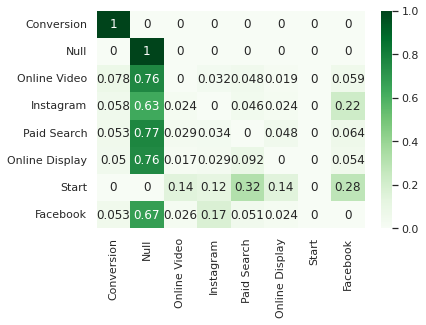

In [ ]:
sns.heatmap(data=transition_matrix, annot=True, cmap='Greens')

## Assessing Removal Effect
A Markov graph can be used to measure the importance of each campaign by calculating what is known as the Removal Effect. A campaign’s effectiveness is determined by removing it from the graph and simulating buyer journeys to measure the change in success rate without it in place. Removal Effect is a proxy for weight, and it’s calculated for each campaign in the Markov graph.

Using Removal Effect for marketing attribution is the final piece of the puzzle. To calculate each campaign’s attribution value we can use the following formula: A = V * (Rt / Rv)

- A = Campaign’s attribution value
- V = Total value to divide. For example, the total USD value of all successful buyer journeys used as input to the Markov model
- Rt = Campaign’s Removal Effect
- Rv = Sum of all Removal Effect values

In [ ]:
# channels = [col for col in transition_matrix.columns.tolist() 
#             if col not in ['Start','Null', 'Conversion']]
# channels

# removal_effect_dict = {}
# chnl = channels[0]
# removal_df = transition_matrix.drop(chnl, axis=0).drop(chnl,  axis=1)
# sel_col = removal_df.columns[2]; sel_col
# row_sum=np.sum(removal_df.loc[sel_col])
# removal_df.loc[sel_col,'Null']= 1.0 - row_sum
# removal_to_conv = removal_df[['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
# removal_to_non_conv = removal_df.drop(['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)
# removal_inv_diff = np.linalg.inv(np.identity(len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
# removal_inv_diff
# removal_dot_prod = removal_inv_diff@np.asarray(removal_to_conv)
# removal_cvr_df = pd.DataFrame(removal_dot_prod, index=removal_to_conv.index)
# removal_cvr = removal_cvr_df[[1]].loc['Start'].values[0]
# removal_effect = 1 -removal_cvr/base_conversion_rate

# removal_effect_dict[chnl] = removal_effect


def get_removal_effect_dict(transition_matrix, base_conversion_rate):
    channels = [col for col in transition_matrix.columns.tolist() 
                if col not in ['Start','Null', 'Conversion']]; channels
    removal_effect_dict = {}
    for chnl in channels:
        removal_df = transition_matrix.drop(chnl, axis=0).drop(chnl,  axis=1)
        for sel_col in removal_df.columns:   
            row_sum=np.sum(removal_df.loc[sel_col])
            removal_df.loc[sel_col,'Null']= 1.0 - row_sum
        removal_to_conv = removal_df[['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)
        removal_inv_diff = np.linalg.inv(np.identity(len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        # removal_inv_diff
        removal_dot_prod = removal_inv_diff@np.asarray(removal_to_conv)
        removal_cvr_df = pd.DataFrame(removal_dot_prod, index=removal_to_conv.index)
        removal_cvr = removal_cvr_df[[1]].loc['Start'].values[0]
        removal_effect = 1 -removal_cvr/base_conversion_rate
        
        removal_effect_dict[chnl] = removal_effect
        
    return removal_effect_dict
    
removal_effect_dict= get_removal_effect_dict(transition_matrix, base_conversion_rate)
removal_effect_dict

{'Online Video': 0.20691411655642178,
 'Instagram': 0.21731366149038456,
 'Paid Search': 0.3311037560086154,
 'Online Display': 0.15435482356041275,
 'Facebook': 0.3547597674182721}

In [ ]:
# removal_df.loc[sel_col],  sel_col # first row,

In [ ]:
# removal_df
total_conversions

In [ ]:
def markov_chain_allocations(removal_effect_dict, total_conversions):
    re_sum = np.sum(list(removal_effect_dict.values()))
    return {k: (v/re_sum)* total_conversions for k,v in removal_effect_dict.items()}

allocations = markov_chain_allocations(removal_effect_dict, total_conversions)
allocations

{'Online Video': 2886.4480895461456,
 'Instagram': 3031.521548555893,
 'Paid Search': 4618.891257291356,
 'Online Display': 2153.2469267590823,
 'Facebook': 4948.892177847523}

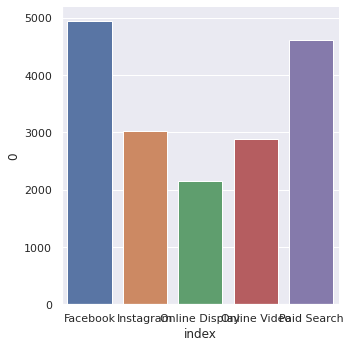

In [ ]:

ax = sns.catplot(data=pd.Series(allocations).sort_index().to_frame().reset_index(),
            x='index', y=0, kind='bar')
# ax.xticks(rotation = 45)